In [74]:
import roadrunner as rr
import tellurium as te
import libsbml as ls
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from tabulate import tabulate

# Specify sbml file path
fn_ant = '../model/Generic_PBK_RT_Grech.ant'
sbml_file = '../model/Generic_PBK_RT_Grech.sbml'

# Specify parametrisations file and instance id
param_file = '../parametrisations/Generic_PBK_RT_Grech_default_params.csv'
param_instance_id = 'Generic_PBK_RT_Grech_PARAM'


## Define helper functions

In [75]:
# Helper function for plotting simulation results
def plotSimulationResults(res, selections, ncols=4):
    nrows = math.ceil((len(selections) - 1)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()
    for ax in axes:
        ax.set(xlabel='time') 
    labels = selections
    for i in range(1, len(selections)):
        sid = selections[i]
        axes[i-1].plot(res['time'], res[sid], linewidth=1)
        axes[i-1].set(ylabel=f"Amount", title=labels[i])
    for j in range(len(selections), nrows*ncols + 1):
        fig.delaxes(axes[j-1])
    fig.tight_layout()

def generateBolusDoseEventsPattern(amount, start, step, stop):
    """ Helper function for generating bolus dosing event patterns """
    timings = range(start, stop, step)
    events = []
    for timing in timings:
        events.append((timing, amount))
    return events

def generateContinuousDoseEventsPattern(amount, duration, start, step, stop):
    """ Helper function for generating continuous dosing event patterns """
    timings = range(start, stop, step)
    events = []
    for timing in timings:
        events.append((timing, amount, duration))
    return events

# Helper function for loading parametrisations
def loadParametrisation(model, filename, idInstance):
    df = pd.read_csv(filename)
    df['Value'] = df['Value'].astype(float)
    df = df.loc[df['idModelInstance'] == idInstance]
    for index, row in df.iterrows():
        model[str(row['Parameter'])] = row['Value']

## Report parametrisation

In [76]:
# Load the PBPK model from the SBML file
rr_model = rr.RoadRunner(sbml_file)

# Load parametrisation
loadParametrisation(rr_model, param_file, param_instance_id)

# Get the SBML model
document = ls.readSBML(sbml_file)
model = document.getModel()

# Create parameters info table
dt_params = []
print("Number of parameters: " + str(model.getNumParameters()))
for i in range(0,model.getNumParameters()):
    s = model.getParameter(i)
    if (s.getConstant()):
        dt_params.append([
            s.getId(),
            rr_model[s.getId()],
            s.getUnits(),
            s.getName()
        ])
df_params = pd.DataFrame(
    dt_params,
    columns=["Id", "Value", "Unit", "Name"]
)
print(tabulate(df_params, headers="keys", tablefmt="fancy_grid", showindex=False))

Number of parameters: 90
╒════════════════════╤═══════════════╤════════╤═════════════╕
│ Id                 │         Value │ Unit   │ Name        │
╞════════════════════╪═══════════════╪════════╪═════════════╡
│ Temperature        │    10         │        │             │
├────────────────────┼───────────────┼────────┼─────────────┤
│ TA                 │  6930         │        │             │
├────────────────────┼───────────────┼────────┼─────────────┤
│ TR_DEB             │   293.65      │        │             │
├────────────────────┼───────────────┼────────┼─────────────┤
│ TR_Fcard           │   279.15      │        │             │
├────────────────────┼───────────────┼────────┼─────────────┤
│ TR_VO2             │   283.15      │        │             │
├────────────────────┼───────────────┼────────┼─────────────┤
│ f_cst              │     1         │        │             │
├────────────────────┼───────────────┼────────┼─────────────┤
│ V_water            │  1000         │       

## Run

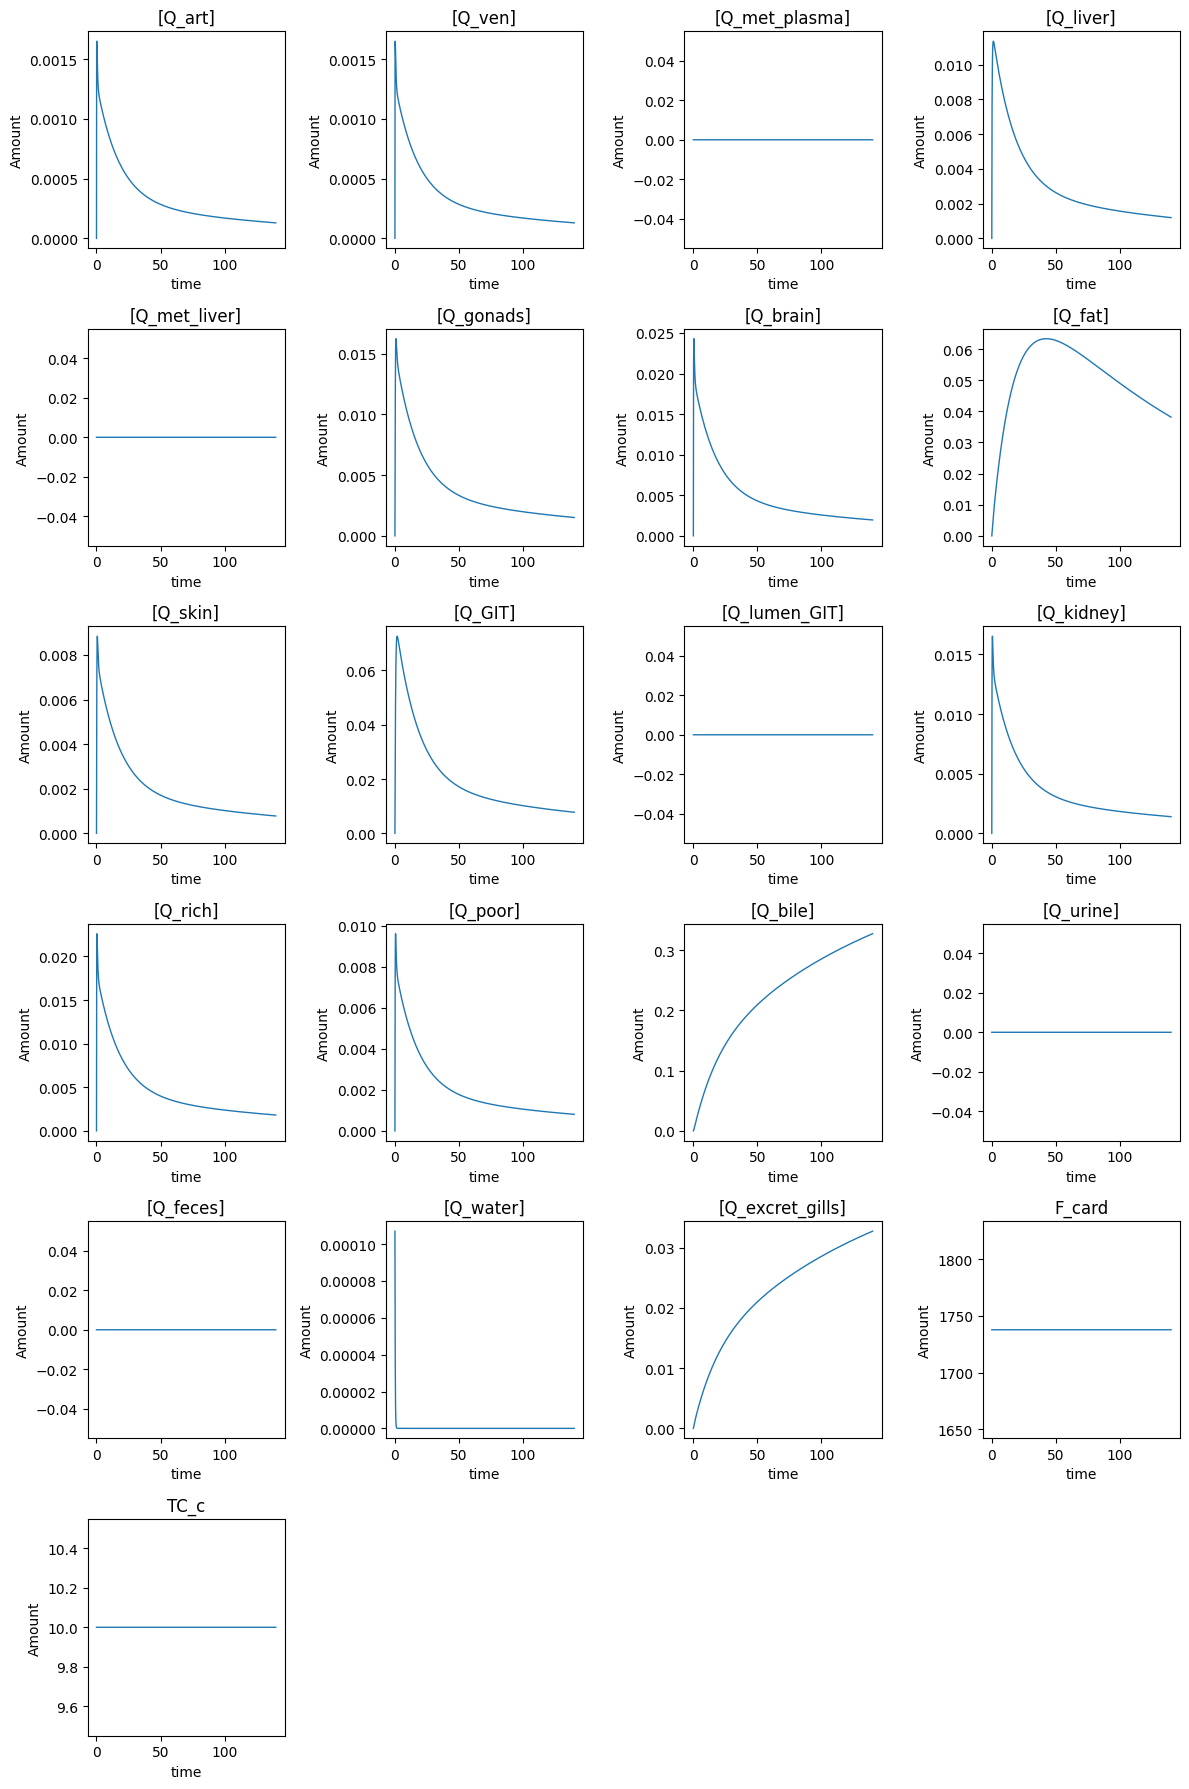

In [77]:
# Load the PBPK model from the SBML file
rr_model = te.loada(fn_ant)
ndays = 140

q_ext = 107 * 10**(-6) * (145000/30)
rr_model.Water = 145000/30

# Set initial amount
water_input = 'Q_water'
rr_model.setInitAmount(water_input, q_ext)
rr_model.setConstant(water_input, False)
rr_model.setBoundary(water_input, False)

# Set initial amount
oral_input = 'Q_lumen_GIT'
rr_model.setInitAmount(oral_input, 0)
rr_model.setConstant(oral_input, False)
rr_model.setBoundary(oral_input, False)

# Load parametrisation
loadParametrisation(rr_model, param_file, param_instance_id)

# Set output parameters
output_params = rr_model.timeCourseSelections + ['F_card', 'TC_c']

# Simulate the PBPK model
results = rr_model.simulate(start=0, end=ndays, points=24*ndays, selections=output_params)

# Plot the results
plotSimulationResults(results, output_params)